In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import joblib


In [2]:
df = pd.read_csv("../data/dataset_ready/features.csv")
print("✅ Dataset cargado:", df.shape)

# Features y etiquetas
X = df[['angle_knee_left', 'angle_knee_right', 'angle_hip_left', 'angle_hip_right',
        'trunk_inclination', 'shoulder_dist', 'hip_dist']]
y = df['label']

# Normalizar (opcional, pero mejora el entrenamiento)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "./models/scaler.pkl")
print("✅ Scaler guardado.")
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)

✅ Dataset cargado: (13361, 9)
✅ Scaler guardado.
Tamaño de entrenamiento: (10688, 7)
Tamaño de prueba: (2673, 7)


In [3]:
# Convertir etiquetas a one-hot encoding (opcional, pero útil)
num_classes = len(df['label'].unique())
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Definir modelo
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\samue\Desktop\Samuel\Inteligencia_Artificial\Proyecto\Pose-activity-detector-\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757 (10.77 KB)

 Trainable params: 2,757 (10.77 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_data=(X_test, y_test_cat))
model.save("./models/movimiento_classifier.h5")
print("✅ Modelo guardado.")

Epoch 1/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3666 - loss: 1.4003 - val_accuracy: 0.4878 - val_loss: 1.1898
Epoch 2/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4558 - loss: 1.2102 - val_accuracy: 0.5181 - val_loss: 1.1253
Epoch 3/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4939 - loss: 1.1401 - val_accuracy: 0.5372 - val_loss: 1.0866
Epoch 4/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5055 - loss: 1.1276 - val_accuracy: 0.5496 - val_loss: 1.0621
Epoch 5/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5156 - loss: 1.0931 - val_accuracy: 0.5447 - val_loss: 1.0444
Epoch 6/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5195 - loss: 1.0798 - val_accuracy: 0.5556 - val_loss: 1.0218
Epoch 7/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5318 - loss: 1.0621 - val_accuracy: 0.5589 - val_loss: 1.0169
Epoch 8/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5313 - loss: 1.0538 - val_accuracy: 0.

✅ Modelo guardado.


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6230 - loss: 0.8432
🔍 Accuracy en prueba: 0.63


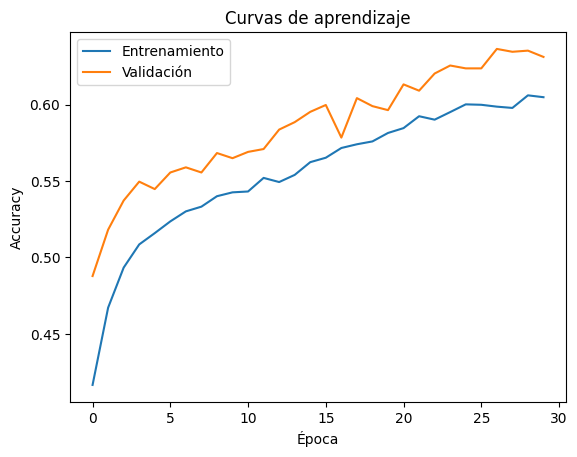

In [6]:
# Evaluar en el set de prueba
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"🔍 Accuracy en prueba: {test_acc:.2f}")

# Visualizar curvas de entrenamiento
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de aprendizaje')
plt.show()

In [ ]:
# Cargar modelo
model = load_model("./models/movimiento_classifier.h5")

# Supongamos que tienes un nuevo vector de features:
new_features = np.array([[130, 125, 120, 115, 75, 0.05, 0.02]])
new_features_scaled = scaler.transform(new_features)

# Predicción
prediction = model.predict(new_features_scaled)
class_idx = np.argmax(prediction)
print("Predicción:", class_idx)